In [11]:
from __future__ import division

# For displaying audio and images in notebook
import IPython.display as ipd

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf
import tfcochleagram

# Helper functions for loading audio
from utils import *

In [2]:
# Starts interactive session -- only run one time. 
sess = tf.InteractiveSession()

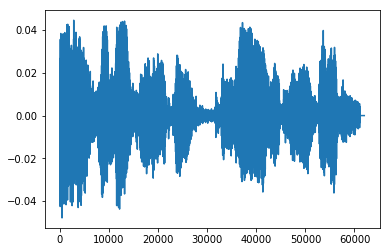

In [3]:
#Import the test_audio
test_audio, SR = load_audio_wav_resample('speech_1.wav', DUR_SECS='full', resample_SR=20000)
# Generally a good idea to rms normalize the audio
test_audio = rms_normalize_audio(test_audio, rms_value=0.01)

plt.plot(test_audio)
ipd.Audio('speech_1.wav')

# Using rFFT below, and it is currently implemented only for even # signals. 
if len(test_audio.ravel())%2:
    test_audio = test_audio[:-1]
    
# make the numpy array of pink noise for later, could use white noise instead. 
pink_noise, rmspink = make_pink_noise(len(test_audio.ravel()),rms_value=0.01)
if len(pink_noise.shape) == 1: # we need to make sure the input node has a first dimension that corresponds to the batch size
    pink_noise = np.expand_dims(pink_noise,0) 


Init Loss = 165.217880
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.714703
  Number of iterations: 474
  Number of functions evaluations: 2821
End Loss = 0.714703
Orig Audio


Synth Audio


Text(0.5,1,'ORIG-SYNTH | cochleagram')

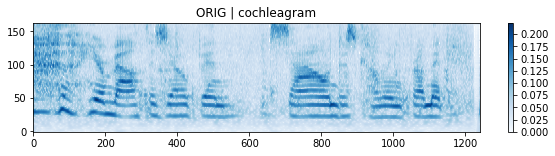

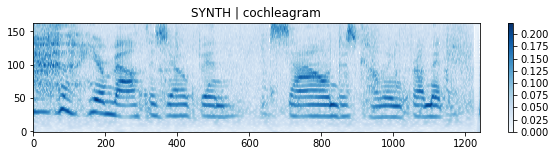

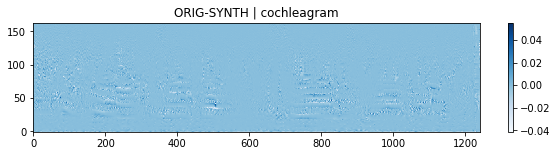

In [10]:
# change the location that you are going to match 
coch_part_to_match = 'cochleagram'

# change the cochleagram parameters
COCH_PARAMS = {
    'compression': 'clipped_point3',
    'SAMPLE_FACTOR': 4,
    'rFFT' : True,
    'N':40,
    'ENV_SR':400,
    'HIGH_LIM':10000, 
    'LOW_LIM':20,
    # These remove the explicit highpass and lowpass filters in pycochleagram
    'erb_filter_kwargs':{'no_highpass':True, 'no_lowpass':True},
}

batch_size = 1

with tf.Graph().as_default():
    test_audio = test_audio - np.mean(test_audio.ravel()) # remove DC
    if len(test_audio.shape) == 1: # we need to make sure the input node has a first dimension that corresponds to the batch size
        test_audio = np.expand_dims(test_audio,0) 
    test_audio_batch = np.repeat(test_audio,batch_size,0)

    nets = {}
    
    # Make the net
    nets['input_signal'] = tf.Variable(test_audio_batch, dtype=tf.float32)
    nets = tfcochleagram.cochleagram_graph(nets, SR, **COCH_PARAMS) 
    
    # op to load the numpy array into the graph
    assign_pink_noise = tf.assign(nets['input_signal'], pink_noise)
    
    with tf.Session() as sess:
        assign_pink_noise.eval()
        orig_values = nets[coch_part_to_match].eval(feed_dict = {nets['input_signal']:test_audio_batch})
        difference = nets[coch_part_to_match] - orig_values
        loss = tf.nn.l2_loss(difference)
        # Here using lbfgs. Can use other optimizers (or losses, such as l1) but might need to change the optimization settings depending on the sounds. 
        # This optimization will take some time, as we set the number of iterations rather high to assure convergence for this demo sound
        # With different initializations and optimizers, the inversion time is often drastically reduced. 
        optm_lbfgs = tf.contrib.opt.ScipyOptimizerInterface(loss, options={'maxiter': 1000, 'ftol':1e-8}, var_list=[nets['input_signal']])
        print('Init Loss = %f'%loss.eval())
        optm_lbfgs.minimize(sess)
        print('End Loss = %f'%loss.eval())
        synth_audio = nets['input_signal'].eval()
        synth_values = nets[coch_part_to_match].eval()
                
plt.figure(figsize=(10,2))
plt.imshow(np.squeeze(orig_values), origin='lower', cmap='Blues', aspect='auto')
plt.colorbar()
plt.title('ORIG | %s'%coch_part_to_match)

print('Orig Audio')
ipd.display(ipd.Audio(data=test_audio, rate=SR)) # load a local WAV file

plt.figure(figsize=(10,2))
plt.imshow(np.squeeze(synth_values), origin='lower', cmap='Blues', aspect='auto')
plt.colorbar()
plt.title('SYNTH | %s'%coch_part_to_match)
print('Synth Audio')
ipd.display(ipd.Audio(data=synth_audio, rate=SR)) # load a local WAV file

plt.figure(figsize=(10,2))
plt.imshow(np.squeeze(orig_values)-np.squeeze(synth_values), origin='lower', cmap='Blues', aspect='auto')
plt.colorbar()
plt.title('ORIG-SYNTH | %s'%coch_part_to_match)
